# Integral Control Analysis

# Preliminaries

In [1]:
pip install tellurium

     |████████████████████████████████| 122kB 4.3MB/s 
     |████████████████████████████████| 14.9MB 238kB/s 
     |████████████████████████████████| 5.6MB 36.4MB/s 
     |████████████████████████████████| 6.2MB 15.0MB/s 
     |████████████████████████████████| 2.5MB 39.1MB/s 
     |████████████████████████████████| 3.1MB 20.1MB/s 
     |████████████████████████████████| 3.2MB 27.2MB/s 
     |████████████████████████████████| 36.7MB 127kB/s 
     |████████████████████████████████| 16.6MB 259kB/s 
     |████████████████████████████████| 27.4MB 163kB/s 
     |████████████████████████████████| 5.8MB 20.5MB/s 
     |████████████████████████████████| 2.0MB 25.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninsta

In [2]:
import tellurium as te
import sympy
from IPython.display import Image
from IPython.core.display import HTML 

In [3]:
sympy.init_printing()

# Helper Functions

In [4]:
def addSymbols(symbolStr):
  """
  Adds the list of symbols in the blank separated string.
  """
  symbols = symbolStr.split(" ")
  globalDct = globals()
  for idx, symbol in enumerate(symbols):
    globalDct[symbol] = sympy.Symbol(symbol)

# Tests
variables = ["aa", "bbb", "fruit"]
symbolStr = " ".join(variables)
addSymbols(symbolStr)
for variable in variables:
  assert(variable in globals())
  delStmt = "del %s" % variable
  exec(delStmt)

# Utilities

In [5]:
def mkSymbolStmt(symbolStr):
  """
  Creaes an executable statement that defines the blank separated symbols in the string.
  """
  symbols = symbolStr.split(" ")
  quotedStrs = ["%s" %s for s in symbols]
  argStrs = ", ".join(symbols)
  return "%s = sympy.symbols(%s)" % (argStrs, quotedStrs)

# Tests
variables = ["aa", "bbb", "fruit"]
symbolStr = " ".join(variables)
stmt = mkSymbolStmt(symbolStr)
exec(stmt)
for variable in variables:
  assert(variable in locals())
  delStmt = "del %s" % variable
  exec(delStmt)

# Implementation of integral feedback control in biological systems
## Reference
Authors: 
Somvanshi, Pramod R.
Patel, Anilkumar K.
Bhartiya, Sharad
Venkatesh, K. V.

Date: 2015

## Analysis

[Feedback Designs](https://drive.google.com/file/d/1GT2hfqxUAo8iiLutB4ccp_mMl59KB8OH/view?usp=sharing)

* P - protein
* A - signaling molecule
* M - metabolite
* E - disturbance

In [6]:
symbols = "dA A K_A E rd_A rd_A1 K_AM Kd_A Kd_M K_Mp A M Mp dP P K_P k_0 M dM K_M rd_M"
exec(mkSymbolStmt(symbols))

In [7]:
def initEquations():
  statements = [
      "dA = K_A * E - Kd_A * A * M",
      "dP = K_P * A - k_0",
      "dM = K_M * P - Kd_M * M",
      "equations = [dA, dP, dM]",
  ]
  return "; ".join(statements)

In [8]:
# Case (a): As written
exec(initEquations())
sympy.solve([dP], A)

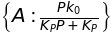

In [9]:
# Case (a) with M.M. kinetics
exec(initEquations())
dP = K_P * A - k_0*P/(1 + P)
sympy.solve([dP], A)

Note that for large $P$, we still get $A = k_0 / K_P$.

In [10]:
# Can still get integral control with unimolecular degradation for A, M in A. Why biomolecular in model?
exec(initEquations())
dA = K_A * E - Kd_A * (A + M)
#
sympy.solve([dP], A)

In [11]:
# Design 1(b): M is activating on A, A inhibits P
exec(initEquations())
dA = K_A * E*M - Kd_A*A
dP = -K_P * A - k_0
#
sympy.solve([dP], A)

1(b) doesn't work because A must be negative since $k_0$ and $K_P$ are positive?

In [12]:
# Design 1(c): Both M and E inhibit A
exec(initEquations())
dA = - K_A * E - Kd_A * A * M
#
sympy.solve([dP], A)

In [13]:
# Design 1(d): E inhibits A; A inhibits P; M activates A
exec(initEquations())
dA = K_AM * M - K_A * E - Kd_A * A
dP = -K_P * A - k_0
#
sympy.solve([dP], A)

Can construct a table with cases defined by:
* E on A
* M on A
* A on P

Theme: Systematic design of integral control based on:
1. the placement of inhibit vs. activate and use of 0th order kinetics
1. which term(s) have 0th order kinetics

# Architecture II: No M

In [14]:
def init2Equations():
  statements = [
      "dA = K_A * E - Kd_A * A * P",
      "dP = K_P * A - k_0",
      "equations = [dA, dP]",
  ]
  return "; ".join(statements)

In [15]:
# Case 2(a): P inhibits A
exec(init2Equations())
sympy.solve([dP], A)

In [16]:
# How much protein is required
newdA = dA.subs(A, k_0/K_P)
sympy.solve(newdA, P)

# Tracking Control

Architecture: P degradation depends on tracking molecule, but it cannot change the level of the molecule.

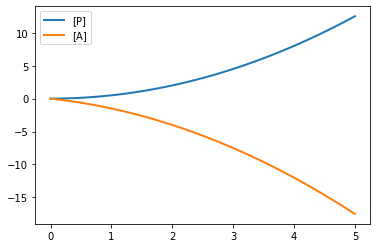

In [17]:
MODEL = """
P -> A; KP_1 * P * M
A -> P; -KA_1 * A
A ->; KA * $M
// E -> A; KE * A

$M = 1
KP_1 = 1
KP_2 = 1
KA_1 = 1
KA = 1
KE = 1
"""

rr = te.loada(MODEL)
rr.plot(rr.simulate())

In [18]:
def init3Equations():
  statements = [
      "dA = K_A * E - Kd_A * A * P",
      "dP = K_P * A - k_0 * M",
      "dM = -k_0 + K_Mp * Mp", 
      "dMp = K_M * M - K_Mp * Mp",
      "equations = [dA, dP]",
  ]
  return "; ".join(statements)

In [19]:
exec(init3Equations())
sympy.solve([dP], A)

In [20]:
exec(init3Equations())
sympy.solve(equations, A)

# Integral Control Paper 1

[Feedback Designs](https://drive.google.com/file/d/1mP0A5jvdlVCtdFCy6QbapDgcsWC_LzmU/view?usp=sharing)

The system including $P$ phosphorylation and dephosphorylation.

* $\dot{S} = k_0 x_0 - k_2 P  + k_6 E$
* $\dot{P} = k_4 x_0 - k_7 P + k_8 Pp$. 
* $\dot{Pp} = k_7 P - k_8 Pp$
* $\dot{x}_1 = k_5 S$

**LaPlace Transforms.**

$s S(s) = k_0 X_0 (s) - k_2 P(s) +k_6 E(s)$

$s P(s) = k_4 X_0 (s) -k_7 P(s) + k_8 Pp(s)$

$s Pp(s) = k_7 P(s) - k_8 Pp(s)$
Or, $Pp(s) = P(s) \frac{k_7}{s + k_8}.$

So,
\begin{align*}
sP(s) & = & k_4 X_0 (s) -k_7 P(s) + k_8 Pp(s) \\
& = & k_4 X_0 (s) -k_7 P(s) + k_8 P(s) \frac{k_7}{s + k_8} \\
P(s)& = & X_0 (s) \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}
\end{align*}

With this,
\begin{align*}
S(s) = X_0(s) \frac{ k_0 - k_2 \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}}{s + k_7} +  E(s) \frac{k_6}{s + k_3}
\end{align*}

\begin{align*}
X_1(s) & = & \frac{k_5}{s}S(s) \\
& = & X_0(s) \frac{k_5}{s}  \frac{ k_0  - k_2 \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}}{s + k_7} +  E(s) \frac{k_5}{s} \frac{k_6}{s + k_3}
\end{align*}

This suggests that the impulse response is finite but the step response is unbounded. Also, $x_t(t) \neq 0$ for a non-zeror $e(t)$.

Note that $k_8$ must be small for the integrator to work.
So,
\begin{align*}
X_1(s) & \approx & X_0(s) \frac{k_5}{s}  \frac{ k_0 - k_2 \frac{k_4 }{s + k_7 }}{s + k_7} +  E(s) \frac{k_5}{s} \frac{k_6}{s + k_3}
\end{align*}

Observe that for an impulse $x_0$, 
$x_1 (\infty) =  k_5 \frac{ k_0 k_7 - k_2 k_4}{ k_7^2} .$

Solve for $H_E (s) = \frac{X_1(s)}{E(s)}$.

$X_0(s) = 0$

$s S(s) =  - k_3 S(s) + k_6 E(s)$ And so,
$S(s) = \frac{k_6 E(s)}{s + k_3}$

Further,
$X_1(s) = \frac{k_5}{s}\frac{k_6 E(s)}{s + k_3} .$

Suggest that there is an error with the impulse response, and the system does not converge with the step response.

Solve for transfer function: $H(s) = \frac{X_1(s)}{X_0(s)}$.

$s S(s) = X_0 (s) \frac{k_0 - k_2 k_4 }{s + k_3}$

$ 
\begin{align*}
X_1 (s) & = &  \frac{k_5}{s} S(s) \\
& = & X_0 (s) \frac{k_5}{s^2}  \frac{k_0 - k_2 k_4 }{s + k_3} \\
H(s) & = & \frac{1}{s^2} \frac{k_0 - k_2 k_4 }{s + k_3}
\end{align*}
$

$H (0)$ is constant and so the output tracks the input. However, the system has complex dynamics.

In [2]:
# Simulation
MODEL = """
$X0 -> S; k0*X0 - k2*P
S -> X1; k4*X0
S -> P; k4*X0
P -> Pp; k7*P
Pp -> P; k8*Pp

$X0 = 1
k0 = 1
k2 = 1
k3
"""

# Integral Paper 2
Analysis of Herbert's early draft.

In [ ]:
addSymbols("P S S_1 S_2 _3")

## Model

* $P \xrightarrow{v_r} S$ has kinetics $v_r (P, E_r) = \frac{k_r E_r P}{K_{M_{r}} + P}$
* $S \xrightarrow{v_f} P$ has kinetics $v_f (S, E_f)
= k_f E_f$ because $S$ saturates the reaciton.

Consider region where $K_{M_r} >> P$ and $E_r$ is stable.
Then, $v_r(P, E_r) \approx k_r E_r P$.

The LaPlace transforms are:
* $\frac{S(s)}{P(s)} = \frac{1}{s} k_r E_r$
* $\frac{S(s)}{E(s)} = \frac{T}{s^2} -  \frac{1}{s} k_f E_f(s)$